In [1]:
import sys
sys.path.append('/pf/a/a270046/hierarchy/pyfesom-master/') # ut.py etc. (github)
import matplotlib
#matplotlib.use('Agg')						#-- use in batch mode
from netCDF4 import Dataset, MFDataset
import pyfesom as pf
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from matplotlib import cm
#from colorbars import cmap_correlations256, cmap_correlations_white, blue_red
import cmocean
import scipy.stats as stats
%matplotlib inline

## Create LGM meshes from existing meshes
##### Select level at depth that will be the new surface grid
##### Thomas Rackow, June 2020

In [11]:
ls /work/ab0995/a270046/meshes_default/

bold/  glob/     ref44k/                  ref87k/
core/  pi-grid/  ref44k_LGM_almostfinal/  tmp-dir/


#### use REF44K grid as example

In [12]:
cp -r /work/ab0995/a270046/meshes_default/ref44k /work/ab0995/a270046/meshes_default/ref44k_LGM

In [13]:
cd /work/ab0995/a270046/meshes_default/ref44k_LGM

/mnt/lustre02/work/ab0995/a270046/meshes_default/ref44k_LGM


In [14]:
ls

aux3d.out        depth.out   elem3d.out   mesh.diag.nc
aux3d.out_orig   dist/       griddes.nc   nod2d.out
Chl_Sweeney.out  elem2d.out  joblib_mesh  nod3d.out


#### open mesh

In [15]:
meshpath = '/work/ab0995/a270046/meshes_default/ref44k_LGM/'
mesh = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=True, usepickle=False, usejoblib=True)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/ab0995/a270046/meshes_default/ref44k_LGM/joblib_mesh


In [16]:
mesh


FESOM mesh:
path                  = /work/ab0995/a270046/meshes_default/ref44k
alpha, beta, gamma    = 0, 0, 0
number of 2d nodes    = 43943
number of 2d elements = 82545
number of 3d nodes    = 1250994

        

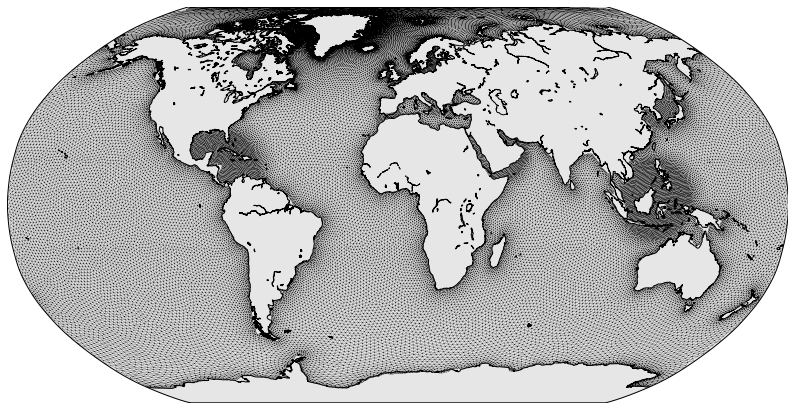

In [17]:
fig=plt.figure(figsize=(14,9))
elem2=mesh.elem[mesh.no_cyclic_elem,:]
voltri = mesh.voltri[mesh.no_cyclic_elem]

map = Basemap(projection='robin',lon_0=0, resolution='l')
x, y = map(mesh.x2, mesh.y2)

map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
plt.triplot(x, y, elem2, lw=0.2,color='k')
#xgrid, ygrid = map(lons_LGM[indeces], lats_LGM[indeces])
#plt.plot(xgrid, ygrid,'ro')
plt.show()

#### select the depth level that will be the new surface

In [18]:
# LGM is 125m below present sea level
mesh.zlevs

array([   -0.,    10.,    20.,    30.,    40.,    50.,    60.,    70.,
          80.,    90.,   100.,   115.,   135.,   160.,   190.,   230.,
         280.,   340.,   410.,   490.,   580.,   680.,   790.,   910.,
        1040.,  1180.,  1330.,  1500.,  1700.,  1920.,  2150.,  2400.,
        2650.,  2900.,  3150.,  3400.,  3650.,  3900.,  4150.,  4400.,
        4650.,  4900.,  5150.,  5400.,  5650.,  6000.])

In [19]:
select_depth=11
depthinm=mesh.zlevs[select_depth]
print(depthinm)

115.0

## Create new *.out files for LGM conditions

#### read 3D indices that describe the type of nodes (in open ocean or on the boundary)

In [20]:
# File looks usually like this:
#
#1250994
#       1 262.983700903  27.850122018      0.0000  11
#       2 262.698406861  26.809608149      0.0000  11
#       3 263.415534178  28.206575155      0.0000  11
#       4 262.816957694  27.342948922      0.0000  11
#       5 263.223246656  26.628488947      0.0000  10
ind3D=np.loadtxt('/work/ab0995/a270046/meshes_default/ref44k_LGM/nod3d.out', dtype=('int'), usecols=(4,), skiprows=1)
# get the last digit as index for our 2D file 
ind2D_def=ind3D % 10 

In [24]:
ind2D_def

array([1, 1, 1, ..., 0, 1, 1])

#### get the layer in the selected depth

In [25]:
# the current 2D grid and the 3D nodes below
mesh.n2d, np.shape(mesh.n32[:,select_depth])

(43943, (43943,))

In [26]:
# our new surface layer, including -999s
meshn2d_LGM=mesh.n32[:,select_depth]
meshn2d_LGM

array([  -999,   -999,   -999, ..., 496181, 496182, 496183])

In [27]:
mask2D=np.arange(0,np.size(meshn2d_LGM))
mask2D

array([    0,     1,     2, ..., 43940, 43941, 43942])

In [28]:
np.arange(meshn2d_LGM[meshn2d_LGM>0].min(), meshn2d_LGM.max()+1)
layerToSurface=np.zeros(meshn2d_LGM.max()+1)

In [29]:
# maps index in layer to the surface index
for node in np.arange(0,meshn2d_LGM.max()+1):
    # print node
    if np.sum(meshn2d_LGM==node)!=0:
        layerToSurface[node] = mask2D[meshn2d_LGM==node][0]

In [30]:
layerToSurface[496183]

43942.0

#### get the elements in that depths

In [44]:
mesh.elem.min(), mesh.elem.max(), mesh.elem.shape, mesh.e2d

(0, 43942, (82545, 3), 82545)

In [45]:
meshn2d_LGM.shape, meshn2d_LGM

((43943,), array([  -999,   -999,   -999, ..., 496181, 496182, 496183]))

In [46]:
meshelem_LGM=meshn2d_LGM[mesh.elem]
meshelem_LGM.shape

(82545, 3)

In [47]:
def find_invalidelems(meshelem, meshn2d_LGM, ind2D_def):
    
    # elements that have 3 dry nodes are invalid
    numLand=np.sum(ind2D_def[meshn2d_LGM[mesh.elem]], axis=1)
    
    # any elements with nodes that are not present at this depth?
    meshelem_LGM=meshn2d_LGM[mesh.elem]
    delelem=np.any(meshelem_LGM[:]==-999, axis=1) # any of the nodes = -999?
    
    return np.logical_or(numLand==3, delelem)

In [48]:
invalidelems=find_invalidelems(mesh.elem, meshn2d_LGM, ind2D_def)

In [49]:
invalidelems.shape, meshelem_LGM.shape, elem2.shape

((82545,), (82545, 3), (82225, 3))

In [50]:
meshelem_LGMreduced=meshelem_LGM[~invalidelems]

In [51]:
meshelem_LGMreduced.shape

(71373, 3)

In [52]:
np.unique(meshelem_LGMreduced).shape

(38379,)

In [53]:
indices, counts=np.unique(meshelem_LGMreduced, return_counts=True)

In [54]:
delnodes=indices[counts==1] # these indices are in one element only, thus pointing into the land
delnodes

array([457898, 457953, 458015, 458170, 458174, 458590, 458664, 458857,
       458954, 458992, 459021, 459170, 459212, 459343, 459474, 459549,
       459565, 459576, 460005, 460075, 460113, 460543, 460574, 461632,
       462159, 462588, 462853, 462871, 462922, 463040, 463160, 463685,
       463748, 463775, 464121, 464142, 464208, 464239, 464268, 464478,
       464568, 464581, 464653, 464829, 464850, 465057, 465084, 465181,
       465293, 465387, 465473, 465555, 465865, 465907, 465929, 465959,
       465988, 466202, 466576, 466759, 466846, 466875, 466957, 467230,
       467311, 467643, 467677, 467684, 467733, 467755, 467756, 467921,
       468075, 468136, 468205, 468252, 468723, 468798, 468857, 468983,
       469359, 469583, 470373, 470602, 470882, 470885, 470890, 470925,
       471032, 471242, 471384, 471753, 471901, 471916, 472185, 472192,
       472208, 472300, 472335, 472422, 472612, 472702, 472758, 473015,
       473045, 473334, 473511, 473535, 473610, 473681, 474121, 474169,
      

In [55]:
delelemlist=list()
for elem in np.arange(0, len(meshelem_LGMreduced)):
    for node in delnodes:
        if np.any(meshelem_LGMreduced[elem,:]==node, axis=0):
            delelemlist.append(elem)
            continue

In [56]:
delelemlist

[1,
 43,
 178,
 207,
 212,
 421,
 512,
 556,
 950,
 1614,
 1616,
 1617,
 1629,
 1653,
 1927,
 1930,
 2050,
 2430,
 2440,
 2482,
 4172,
 4241,
 4303,
 4379,
 4383,
 4713,
 4793,
 5278,
 5683,
 6487,
 6968,
 6988,
 11170,
 11553,
 11572,
 11827,
 12188,
 12405,
 12424,
 12508,
 12510,
 13006,
 14176,
 14182,
 14199,
 14460,
 15760,
 15799,
 15835,
 15839,
 18524,
 19349,
 19547,
 21487,
 21802,
 21951,
 22063,
 22278,
 23292,
 23311,
 23333,
 23412,
 23725,
 24263,
 24385,
 24841,
 26034,
 26880,
 27043,
 28860,
 29097,
 30455,
 30785,
 30785,
 30786,
 30817,
 30835,
 30837,
 31078,
 31268,
 31276,
 31362,
 31430,
 31440,
 31544,
 31619,
 32010,
 32012,
 32478,
 32573,
 32593,
 33417,
 33671,
 33887,
 33890,
 34123,
 34147,
 34306,
 34387,
 34597,
 34643,
 34662,
 34674,
 34674,
 34719,
 34720,
 34733,
 36364,
 36685,
 36924,
 36956,
 36991,
 37030,
 37178,
 38051,
 38084,
 38135,
 38166,
 38218,
 38235,
 39961,
 41714,
 42677,
 42720,
 42723,
 42832,
 42894,
 43134,
 43211,
 43358,
 433

#### delete the elements

In [57]:
meshelem_LGM_furtherreduced=np.delete(meshelem_LGMreduced, np.array(delelemlist), axis=0)

In [58]:
meshelem_LGM_furtherreduced.shape, meshelem_LGMreduced.shape, np.array(delelemlist).shape

((71141, 3), (71373, 3), (234,))

#### delete the according nodes

In [59]:
meshn2d_LGM_furtherreduced=np.unique(meshelem_LGM_furtherreduced)

In [60]:
meshn2d_LGM_furtherreduced.min(), meshn2d_LGM_furtherreduced.max(), meshn2d_LGM_furtherreduced.shape

(457679, 496183, (38141,))

In [61]:
indices,counts=np.unique(meshelem_LGM_furtherreduced, return_counts=True)
np.sum(counts==1)

55

In [62]:
delnodes=indices[counts==1] # these indices are in one element only, thus pointing into the land
delnodes

array([457954, 458181, 458680, 458795, 459458, 459524, 460056, 462923,
       462998, 464256, 465083, 465085, 465866, 466014, 466673, 467005,
       467282, 467682, 468213, 468238, 469024, 469584, 470627, 471370,
       472782, 473001, 473722, 474791, 474929, 475626, 476370, 477057,
       478289, 478495, 479249, 479605, 479674, 482088, 483513, 483713,
       483925, 484045, 484086, 484104, 484619, 484822, 484894, 485104,
       485784, 488350, 490578, 492363, 492923, 493018, 493033])

In [63]:
delelemlist=list()
for elem in np.arange(0, len(meshelem_LGM_furtherreduced)):
    for node in delnodes:
        if np.any(meshelem_LGM_furtherreduced[elem,:]==node, axis=0):
            delelemlist.append(elem)
            continue

In [64]:
# delete elems
meshelem_LGM_furtherreduced2=np.delete(meshelem_LGM_furtherreduced, np.array(delelemlist), axis=0)

In [65]:
# delete the nodes
meshn2d_LGM_furtherreduced2=np.unique(meshelem_LGM_furtherreduced2)

In [66]:
indices,counts=np.unique(meshelem_LGM_furtherreduced2, return_counts=True)
np.sum(counts==1)

11

In [67]:
delnodes=indices[counts==1] # these indices are in one element only, thus pointing into the land

delelemlist=list()
for elem in np.arange(0, len(meshelem_LGM_furtherreduced2)):
    for node in delnodes:
        if np.any(meshelem_LGM_furtherreduced2[elem,:]==node, axis=0):
            delelemlist.append(elem)
            continue

In [68]:
# delete elems
meshelem_LGM_furtherreduced3=np.delete(meshelem_LGM_furtherreduced2, np.array(delelemlist), axis=0)
# delete the nodes
meshn2d_LGM_furtherreduced3=np.unique(meshelem_LGM_furtherreduced3)

In [69]:
indices,counts=np.unique(meshelem_LGM_furtherreduced3, return_counts=True)
np.sum(counts==1)

9

In [70]:
delnodes=indices[counts==1] # these indices are in one element only, thus pointing into the land

delelemlist=list()
for elem in np.arange(0, len(meshelem_LGM_furtherreduced3)):
    for node in delnodes:
        if np.any(meshelem_LGM_furtherreduced3[elem,:]==node, axis=0):
            delelemlist.append(elem)
            continue

In [71]:
# delete elems
meshelem_LGM_furtherreduced4=np.delete(meshelem_LGM_furtherreduced3, np.array(delelemlist), axis=0)
# delete the nodes
meshn2d_LGM_furtherreduced4=np.unique(meshelem_LGM_furtherreduced4)

In [72]:
indices,counts=np.unique(meshelem_LGM_furtherreduced4, return_counts=True)
np.sum(counts==1)

8

In [73]:
def iterate(meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced):
    
    indices,counts=np.unique(meshelem_LGM_furtherreduced, return_counts=True)
    print np.sum(counts==1)
    
    delnodes=indices[counts==1] # these indices are in one element only, thus pointing into the land

    delelemlist=list()
    for elem in np.arange(0, len(meshelem_LGM_furtherreduced)):
        for node in delnodes:
            if np.any(meshelem_LGM_furtherreduced[elem,:]==node, axis=0):
                delelemlist.append(elem)
                continue
                
    # delete elems
    meshelem_LGM_furtherreduced1=np.delete(meshelem_LGM_furtherreduced, np.array(delelemlist), axis=0)
    # delete the nodes
    meshn2d_LGM_furtherreduced1=np.unique(meshelem_LGM_furtherreduced1)
    
    return meshelem_LGM_furtherreduced1, meshn2d_LGM_furtherreduced1

In [74]:
meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced = iterate(meshelem_LGM_furtherreduced3, meshn2d_LGM_furtherreduced3)

9


In [75]:
meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced = iterate(meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced)

8


In [76]:
meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced = iterate(meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced)

1


In [77]:
meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced = iterate(meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced)

1


In [78]:
meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced = iterate(meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced)

1


In [79]:
meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced = iterate(meshelem_LGM_furtherreduced, meshn2d_LGM_furtherreduced)

0


#### DONE!

In [116]:
meshelem_LGM_furtherreduced.shape, meshn2d_LGM_furtherreduced.shape

((71059, 3), (38055,))

In [117]:
np.sum(np.unique(meshelem_LGM_furtherreduced)==meshn2d_LGM_furtherreduced)

38055

In [118]:
meshn2d_LGM_furtherreduced.shape

(38055,)

In [119]:
meshn2d_LGM.shape, meshn2d_LGM.min(), meshn2d_LGM.max()

((43943,), -999, 496183)

In [120]:
meshn2d_LGM_furtherreduced

array([457679, 457680, 457682, ..., 496181, 496182, 496183])

In [121]:
surfacenode=np.zeros_like(meshn2d_LGM_furtherreduced)
i=-1
# maps index in layer to the surface index
for node in meshn2d_LGM_furtherreduced:
    # print node
    #if np.sum(meshn2d_LGM==node)!=0:
    i=i+1
    surfacenode[i] = mask2D[meshn2d_LGM==node][0]

In [122]:
surfacenode.min()-3, surfacenode.max()-3, surfacenode.shape

(1, 43939, (38055,))

In [123]:
surfacenode
# coordinates for the valid points
lons_LGM = mesh.x2[surfacenode]
lats_LGM = mesh.y2[surfacenode]
# index
ind2D_LGM=ind2D_def[meshn2d_LGM_furtherreduced]

In [124]:
meshn2d_LGM_furtherreduced.shape, surfacenode.shape

((38055,), (38055,))

In [125]:
num_points=np.shape(meshn2d_LGM_furtherreduced)[0]
X = np.array([np.arange(1,num_points+1), lons_LGM, lats_LGM, ind2D_LGM])

np.savetxt('nod2d.out.LGM', X.T, fmt=('    %d','%10.9f',' %10.9f','        %d'), delimiter=' ', comments='', header=str(num_points)) # comments is empty string, for the header

In [126]:
!head -20 nod2d.out.LGM

38055
    1 -96.776753344  26.628488947         1
    2 -97.533254744  24.573159749         1
    3 -96.523250212  27.625114776         1
    4 -96.655680366  27.126487496         1
    5 -97.071294647  26.184444123         1
    6 -97.218876097  25.638066970         1
    7 -97.378418170  25.100044629         0
    8 -96.960655527  24.648705822         0
    9 -97.133314405  24.068122799         1
    10 -97.723031306  23.078014749         1
    11 -95.991706059  27.902460922         0
    12 -96.788251908  25.208532915         0
    13 -96.690796269  23.724098677         0
    14 -97.148066573  23.431458795         1
    15 -97.826290204  22.553629663         1
    16 -97.692919219  22.024920646         0
    17 -96.004311966  27.344215318         0
    18 -96.167470491  26.799658698         0
    19 -96.386763204  26.253479744         0


In [127]:
surfacenode.min()-3, surfacenode.max()-3, surfacenode.shape

(1, 43939, (38055,))

In [128]:
num_elements=np.shape(meshelem_LGM_furtherreduced)[0]
np.shape(meshelem_LGM_furtherreduced)

(71059, 3)

In [129]:
meshelem_LGM_furtherreduced

array([[476157, 476173, 476204],
       [485741, 485577, 485576],
       [490391, 490365, 490390],
       ..., 
       [488867, 488888, 488849],
       [488867, 488887, 488888],
       [488867, 488866, 488887]])

In [130]:
meshelem_write=layerToSurface[meshelem_LGM_furtherreduced]

In [131]:
meshelem_write.min(), meshelem_write.max(), num_elements

(4.0, 43942.0, 71059)

In [146]:
newsurfacenodes=np.arange(1,num_points+1) #new numbering
newsurfacenodes, surfacenode

(array([    1,     2,     3, ..., 38053, 38054, 38055]),
 array([    4,     5,     8, ..., 43940, 43941, 43942]))

In [161]:
def renumbering(surfacenode, newsurfacenodes):
    
    renumber=np.zeros(np.max(surfacenode)+1)
    
    num=1
    for i in surfacenode:
        renumber[i]=num
        num=num+1
        
    return renumber.astype(int)

In [162]:
renumber=renumbering(surfacenode, newsurfacenodes)

In [164]:
renumber[43942], renumber[4], renumber[8], renumber[43940]

(38055, 1, 3, 38053)

In [169]:
renumber, renumber[meshelem_write.astype(int)]

(array([    0,     0,     0, ..., 38053, 38054, 38055]),
 array([[18267, 18283, 18313],
        [27719, 27558, 27557],
        [32314, 32290, 32313],
        ..., 
        [30796, 30817, 30778],
        [30796, 30816, 30817],
        [30796, 30795, 30816]]))

In [170]:
np.savetxt('elem2d.out.LGM', renumber[meshelem_write.astype(int)], fmt=('      %d','       %d','       %d'), delimiter=' ', comments='', header=str(num_elements)) # comments is empty string, for the header

In [171]:
!head -20 elem2d.out.LGM

71059
      18267        18283        18313
      27719        27558        27557
      32314        32290        32313
      32377        32315        32341
      27457        27283        27323
      27323        27283        27230
      25180        25259        24955
      24955        24954        25180
      20946        20945        21137
      20792        20945        20946
      21216        20433        20527
      20527        21493        21216
      3122        2930        2993
      19853        19321        18892
      25180        24954        25042
      27576        27433        27354
      27576        27757        27433
      27374        27339        27404
      27404        27339        27210


In [172]:
mkdir -p /work/ab0995/a270046/meshes_default/ref44k_LGM_final

In [173]:
cp /work/ab0995/a270046/meshes_default/ref44k_LGM/*.LGM /work/ab0995/a270046/meshes_default/ref44k_LGM_final/

In [174]:
mv /work/ab0995/a270046/meshes_default/ref44k_LGM_final/nod2d.out.LGM /work/ab0995/a270046/meshes_default/ref44k_LGM_final/nod2d.out

In [175]:
mv /work/ab0995/a270046/meshes_default/ref44k_LGM_final/elem2d.out.LGM /work/ab0995/a270046/meshes_default/ref44k_LGM_final/elem2d.out

In [176]:
meshpath = '/work/ab0995/a270046/meshes_default/ref44k_LGM_final/'
mesh = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=False, usepickle=False, usejoblib=False)

Load 2d part of the grid in 0 second(s)


In [177]:
mesh


FESOM mesh:
path                  = /work/ab0995/a270046/meshes_default/ref44k_LGM_final
alpha, beta, gamma    = 0, 0, 0
number of 2d nodes    = 38055
number of 2d elements = 71059
number of 3d nodes    = 0

        

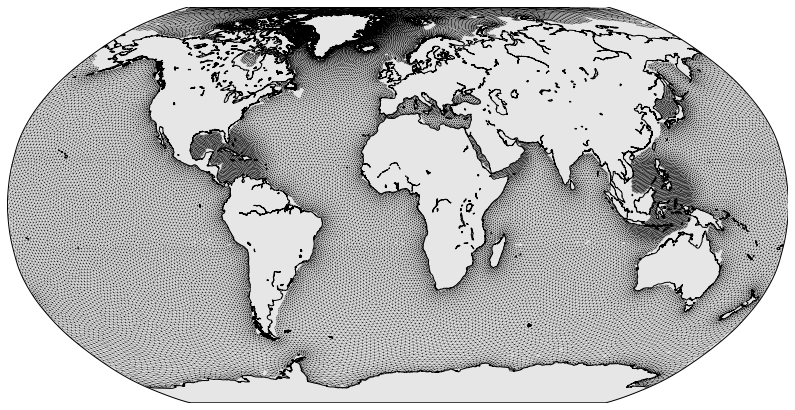

In [178]:
fig=plt.figure(figsize=(14,9))
elem2=mesh.elem[mesh.no_cyclic_elem,:]
voltri = mesh.voltri[mesh.no_cyclic_elem]

map = Basemap(projection='robin',lon_0=0, resolution='l')
x, y = map(mesh.x2, mesh.y2)

map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
plt.triplot(x, y, elem2, lw=0.2,color='k')
#xgrid, ygrid = map(lons_LGM[indeces], lats_LGM[indeces])
#plt.plot(xgrid, ygrid,'ro')
plt.show()

#### compute depths

In [187]:
!head -20 depth.out

    -50 
    -72 
    -63 
    -64 
   -276 
   -266 
   -309 
    -71 
   -187 
   -250 
   -184 
   -179 
   -211 
   -683 
   -770 
   -468 
   -453 
   -240 
   -586 
  -1435 


In [188]:
depthIN=np.loadtxt('/work/ab0995/a270046/meshes_default/ref44k_LGM/depth.out', dtype=('int'), usecols=(0,), skiprows=0)

In [189]:
#depthinm=-115.0

In [191]:
depthOUT=depthIN[surfacenode]+int(np.abs(depthinm))

In [192]:
np.savetxt('depth.out.LGM', depthOUT, fmt=('%d'))

In [193]:
!head -20 depth.out.LGM

-161
-151
-72
-135
-69
-64
-96
-568
-655
-338
-125
-471
-1320
-853
-260
-299
-358
-489
-483
-423


In [194]:
depthOUT.max(), depthOUT.min(), depthIN.max(), depthIN.min()

(9, -5885, -30, -6000)

In [195]:
depthOUT[depthOUT>=-30]=-30

In [196]:
depthOUT.max(), depthOUT.min(), depthIN.max(), depthIN.min()

(-30, -5885, -30, -6000)

In [197]:
np.savetxt('depth.out.LGM', depthOUT, fmt=('%d'))

In [198]:
!head -20 depth.out.LGM

-161
-151
-72
-135
-69
-64
-96
-568
-655
-338
-125
-471
-1320
-853
-260
-299
-358
-489
-483
-423


In [203]:
elem2=mesh.elem[mesh.no_cyclic_elem,:]
voltri = mesh.voltri[mesh.no_cyclic_elem]

map = Basemap(projection='robin',lon_0=0, resolution='l')
x, y = map(mesh.x2, mesh.y2)

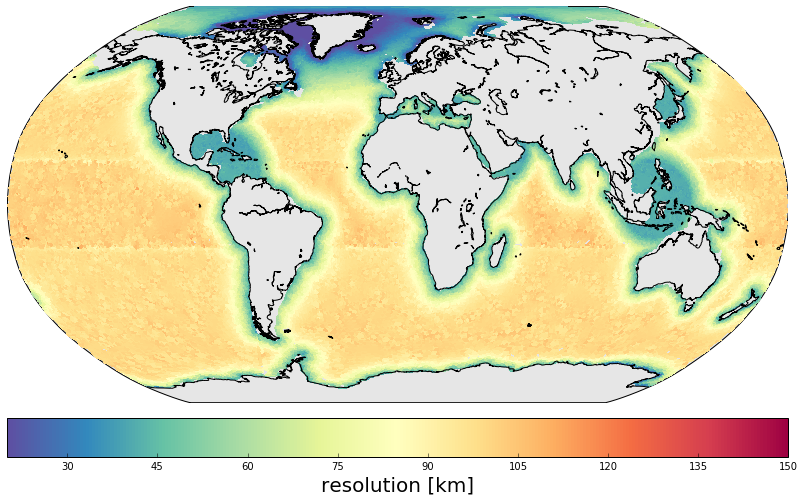

In [204]:
fig=plt.figure(figsize=(14,9))
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
plt.tripcolor(x, y, elem2, \
              facecolors=np.sqrt(voltri)/1000., \
              edgecolors='none',\
             cmap=cm.Spectral_r,
              vmin=20.,vmax=150.)
cbar=plt.colorbar(orientation='horizontal', pad=0.03)
cbar.set_label('resolution [km]', fontsize=20)
plt.show()

In [202]:
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/REF44K_LGM_color.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

In [206]:
pwd

u'/mnt/lustre02/work/ab0995/a270046/meshes_default/ref44k_LGM'

In [209]:
# copy the bathymetry to the final folder
!cp /work/ab0995/a270046/meshes_default/ref44k_LGM/depth.out.LGM /work/ab0995/a270046/meshes_default/ref44k_LGM_final/depth.out

In [210]:
cd /work/ab0995/a270046/meshes_default/ref44k_LGM_final/

/mnt/lustre02/work/ab0995/a270046/meshes_default/ref44k_LGM_final


In [211]:
ls

depth.out  elem2d.out  nod2d.out


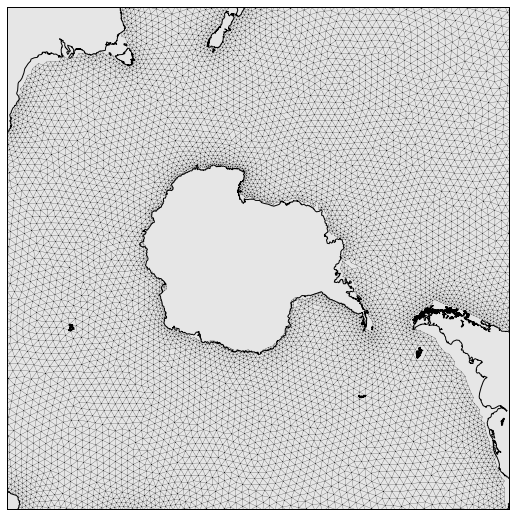

In [218]:
fig=plt.figure(figsize=(14,9))
#elem2=mesh.elem[mesh.no_cyclic_elem,:]
#voltri = mesh.voltri[mesh.no_cyclic_elem]

map = Basemap(projection='spstere', boundinglat=-40., lon_0=0., resolution='l')
x, y = map(mesh.x2, mesh.y2)

map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
plt.triplot(x, y, mesh.elem, lw=0.2,color='k')
#xgrid, ygrid = map(lons_LGM[indeces], lats_LGM[indeces])
#plt.plot(xgrid, ygrid,'ro')
plt.show()

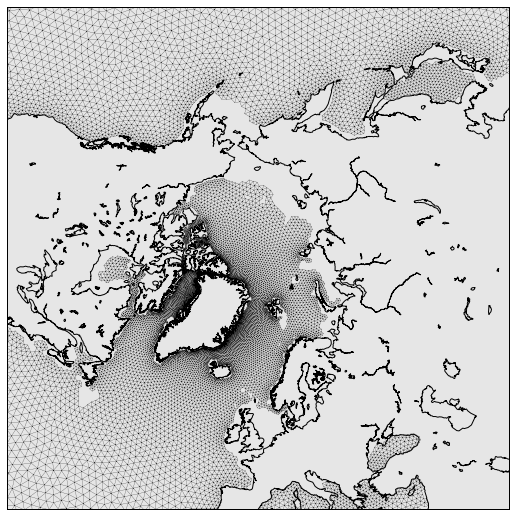

In [219]:
fig=plt.figure(figsize=(14,9))
#elem2=mesh.elem[mesh.no_cyclic_elem,:]
#voltri = mesh.voltri[mesh.no_cyclic_elem]

map = Basemap(projection='npstere', boundinglat=40., lon_0=0., resolution='l')
x, y = map(mesh.x2, mesh.y2)

map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
plt.triplot(x, y, mesh.elem, lw=0.2,color='k')
#xgrid, ygrid = map(lons_LGM[indeces], lats_LGM[indeces])
#plt.plot(xgrid, ygrid,'ro')
plt.show()